<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/Generative-CDTL_0904.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concept drift tolerant machine learning method

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 실험을 위한 기본적인 function 들...

In [4]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
#from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

In [5]:
main_figsize=(15,3)

plt.rc('font', size=10)        # 기본 폰트 크기
plt.rc('axes', labelsize=10)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=10)  # x축 눈금 폰트 크기
plt.rc('ytick', labelsize=10)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=10)  # 범례 폰트 크기
plt.rc('figure', titlesize=10) # figure title 폰트 크기


In [6]:
def weights_init_normal(m):
    """Initializes the weight and bias of the model.

    Args:
        m: A torch model to initialize.

    Returns:
        None.
    """

    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('Linear') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.2)
        torch.nn.init.constant_(m.bias.data, 0)


In [7]:
# Define the Generator
# bucket에 대해 x를 전처리
class Generator(nn.Module):

    def __init__(self,input_dim):
        super(Generator, self).__init__()

        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        #self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(2, self.input_dim*10))
            #self.fc2.append(nn.BatchNorm1d(num_features=50))
            self.fc3.append(nn.Linear(self.input_dim*10, 1))

        #self.fc = nn.Linear(input_dim, input_dim)

    def forward(self,x,b):
        pxy = []
        for i in range(self.input_dim):
            h0 = self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1))
            #h1 = F.relu(self.fc2[i](h0))
            #h2 = self.fc3[i](h1)
            h2 = self.fc3[i](F.relu(h0))
            pxy.append(h2)

        #return self.fc(torch.tensor(torch.cat(pxy, dim=1), requires_grad = True))
        return torch.cat(pxy, dim=1)


In [8]:
# Define the Discriminator
# 비즈니스에 해당하는 모델
class Discriminator(nn.Module):

    def __init__(self, input_dim=5):
        """Initializes Discriminator with torch components."""
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, input_dim*4),
            nn.ReLU(),
            nn.Linear(input_dim*4, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.

        Args:
            input_data: The input data.

        Returns:
            The predicted label (y_hat) for the given input data.
        """

        output = self.model(input_data)
        return output


In [9]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
import scipy

def test_model(model_,model2_, train_tensors, test_tensors, avaible_range,columns):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test

    model_.eval()

    b_dim = XS_test.shape[1]-1

    #test_analysis = {}
    XS = XS_train[:,b_dim].cpu().data.numpy()
    '''
    for bk in np.unique(XS,axis = 0):
        test_analysis[f'Sum(MI{bk})']= []
        test_analysis[f'Std(MI{bk})']= []
        test_analysis[f'Ent(MI{bk})']= []

        test_analysis[f'Sum(DR{bk})']= []
        test_analysis[f'Std(DR{bk})']= []
        test_analysis[f'Ent(DR{bk})']= []

    test_analysis['TrainSum(MI)']= []
    test_analysis['TrainStd(MI)']= []
    test_analysis['TrainEnt(MI)']= []

    test_analysis['Test Sum(MI)']= []
    test_analysis['Test Std(MI)']= []
    test_analysis['Test Ent(MI)']= []

    test_analysis['Test Sum(DR)']= []
    test_analysis['Test Std(DR)']= []
    test_analysis['Test Ent(DR)']= []
    '''
    if model2_ == None:
        ax = XS_test[:,0:b_dim]
        ref_ax = XS_train[:,0:b_dim]
    else:
        model2_.eval()
        ax = model2_(XS_test[:,0:b_dim],XS_test[:,b_dim].reshape(-1,1)/avaible_range)
        ref_ax = model2_(XS_train[:,0:b_dim],XS_train[:,b_dim].reshape(-1,1)/avaible_range)

    y_hat = model_(ax)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    ty_ = y_test.data.numpy()
    f1 = f1_score(ty_,y_hat)
    '''
    #################### Test (f(x'),y) #########################
    ax_df = pd.DataFrame(ax.cpu().data.numpy(),columns=columns)
    mi_scores = make_mi_scores(ax_df, ty_, discrete_features="auto")
    #test_analysis['Test Sum(MI)'].append(np.sum(mi_scores))
    #test_analysis['Test Std(MI)'].append(np.std(mi_scores))
    #test_analysis['Test Ent(MI)'].append(scipy.stats.entropy(mi_scores))

    ks = __ks_drift(ax_df.values,XS_test[:,0:b_dim].cpu().data.numpy())
    #test_analysis['Test Sum(DR)'].append(np.sum(ks[:,0]))
    #test_analysis['Test Std(DR)'].append(np.std(ks[:,0]))
    #test_analysis['Test Ent(DR)'].append(scipy.stats.entropy(ks[:,0]))

    #################### Train (f(x'),y) #########################
    ax_df = pd.DataFrame(ref_ax.cpu().data.numpy(),columns=columns)
    mi_scores = make_mi_scores(ax_df, y_train.data.numpy(), discrete_features="auto")
    #test_analysis['TrainSum(MI)'].append(np.sum(mi_scores))
    #test_analysis['TrainStd(MI)'].append(np.std(mi_scores))
    #test_analysis['TrainEnt(MI)'].append(scipy.stats.entropy(mi_scores))

    #################### Train (f(x'_b),y_b) #########################
    '''
    '''
    for bk in np.unique(XS,axis = 0):
        inx = np.where(XS==bk)[0]
        #print(XS_train[:,b_dim].cpu().data.numpy())
        if model2_ == None:
            ax = XS_train[inx][:,0:b_dim]
        else:
            ax = model2_(XS_train[inx][:,0:b_dim],XS_train[inx][:,b_dim].reshape(-1,1)/avaible_range)


        ty_ = y_train[inx].data.numpy()

        ax_df = pd.DataFrame(ax.cpu().data.numpy(),columns=columns)
        mi_scores = make_mi_scores(ax_df, ty_, discrete_features="auto")
        #test_analysis[f'Sum(MI{bk})'].append(np.sum(mi_scores))
        #test_analysis[f'Std(MI{bk})'].append(np.std(mi_scores))
        #test_analysis[f'Ent(MI{bk})'].append(scipy.stats.entropy(mi_scores))

        ks = __ks_drift(XS_train[:,0:b_dim].cpu().data.numpy(),ax_df.values)
        #test_analysis[f'Sum(DR{bk})'].append(np.sum(ks[:,0]))
        #test_analysis[f'Std(DR{bk})'].append(np.std(ks[:,0]))
        #test_analysis[f'Ent(DR{bk})'].append(scipy.stats.entropy(ks[:,0]))
    '''
    print("Test f1 score: {}".format(f1))

    #test_analysis_df = pd.DataFrame(test_analysis)
    #print(test_analysis_df)

    return f1#,test_analysis_df

In [10]:

def test_all_data(discriminator,generator,X_train, X_live, Y_live, train_size, test_size, avaible_range, columns, ShowChart = False,bucket_size_array=[200]):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print('X_live.shape',X_live.shape)
    b_dim = X_live.shape[1]-1
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = xl.shape[0] #truncate_count + len(xl)
            break


    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set),dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []
    MISS = {}
    DRF = {}
    for col in columns:
        MISS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        if generator == None:
            xs = X_live_unit[:,0:b_dim]
        else:
            xs = generator(X_live_unit[:,0:b_dim],X_live_unit[:,b_dim].reshape(-1,1)/avaible_range)
        predicted_y = discriminator(xs)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
        f1s.append(f1_)

        cpu_xs = xs.cpu().data.numpy()
        mi_scores = make_mi_scores(pd.DataFrame(cpu_xs,columns=columns), Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,cpu_xs)
        for ix,col in enumerate(columns):
            MISS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MISS)
    df_drf = pd.DataFrame(DRF)

    if ShowChart:
        plt.figure(figsize=main_figsize)
        plt.plot(f1s,linewidth=1)
        plt.ylabel('F1 Score')
        plt.xlabel(f'bucket ({test_size})')
        plt.show()

        df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

        df_drf.plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

    print(f'mean of drift:\n{df_drf.mean()}')
    print('Mean F1 for all data:',np.mean(f1s))

    return f1s, df_mis, df_drf

In [11]:
H=20

class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()
        #self.fc4 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(1, H))
            self.fc2.append(nn.Linear(1, H))
            self.fc3.append(nn.Linear(H, 1))

    def forward(self, x, y):
        h = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](x[:,i].reshape(-1,1))+self.fc2[i](y.reshape(-1,1)))
            h1 = self.fc3[i](h0)
            h.append(h1)

        mi = torch.cat(h, dim=1)
        return mi

class customLoss(nn.Module):
    def __init__(self, model):
        super(customLoss, self).__init__()
        self.model = model

    def forward(self, x,y):
        minibatch = int(x.shape[0] * 0.8)
        s = np.random.choice(x.shape[0],minibatch)
        #x_sample = Variable(torch.from_numpy(x[s,:]).type(torch.FloatTensor), requires_grad = True)
        #y_sample = Variable(torch.from_numpy(y[s]).type(torch.FloatTensor), requires_grad = True)
        #y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[s])).type(torch.FloatTensor), requires_grad = True)
        x_sample = x[s,:] #Variable(x[s,:], requires_grad = True)
        y_sample = y[s] #Variable(, requires_grad = True)
        y_shuffle = y[torch.randperm(minibatch)] #Variable(, requires_grad = True)
        p_xy = self.model(x_sample, y_sample)
        p_x_y = self.model(x_sample, y_shuffle)
        ret = torch.mean(p_xy,0) - torch.log(torch.mean(torch.exp(p_x_y),0))
        loss = - ret

        return loss #, ret.sum().reshape(-1,)

In [12]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, avaible_range, alpha, columns,ShowChart = False, do_mine=True):
    #seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    lambda_f = torch.tensor([lambda_f],dtype=torch.float32).to(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    #s1_test = test_tensors.s1_test.to(device)

    # Saves return values here
    #test_result = []

    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch

    b_dim = XS_train.shape[1]-1

    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    a_losses = []
    m_losses =[]
    f_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss(reduce=False)  # mean square error

    # Initializes generator and discriminator
    discriminator = Discriminator(b_dim).to(device)
    discriminator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(discriminator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]


    adapter = Generator(b_dim).to(device)
    #adapter.apply(weights_init_normal)

    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net(b_dim).to(device)

    mine_loss = customLoss(mine).to(device)
    optimizer_M = torch.optim.Adam(mine_loss.parameters(), lr=0.001)
    #kld_loss = nn.KLDivLoss(reduction='batchmean')
    default_value = torch.tensor([0.5],dtype=torch.float32).to(device)
    for epoch in tqdm(range(n_epochs)):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------

        if lambda_f >= 0.0:
            xs = adapter(XS_train[:,0:b_dim],XS_train[:,b_dim].reshape(-1,1)/avaible_range) # z0, b

            #org = torch.histc(XS_train[:,0:b_dim], bins=100, min=0, max=1)
            #trg = torch.histc(xs, bins=100, min=0, max=1)

            ml = torch.mean(mse_loss(xs, XS_train[:,0:b_dim]),dim=0)

            ## distribution의 변차를 최소화 한다. kld_loss ??
            #kl = torch.mean(kld_loss(trg.log(), org),dim=0)
            #
            a_loss =  torch.sum(ml) + torch.std(ml)
        else:
            xs = XS_train[:,0:b_dim]
            a_loss = torch.tensor(0.0)

        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = discriminator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) #+ torch.log(mine_loss.mean()+1)*0.001

        optimizer_A.zero_grad()
        #optimizer_M.zero_grad()
        optimizer_G.zero_grad()
        '''
        if lambda_f >= 0.0:
            # -------------------
            #  Forwards MINE
            # -------------------

            xs_test = adapter(XS_test[:,0:b_dim],XS_test[:,b_dim].reshape(-1,1)/avaible_range)
            #x_sample = Variable(torch.clone(xs_test), requires_grad = True)

            m_loss, lmd = mine_loss(xs_test,
                                    y_test, #generator(xs_test).reshape(-1,1),
                                    default_value)

            m_losses.append(-m_loss.cpu().data.numpy())
            f_losses.append(lmd.cpu().data.numpy())

            m_loss = m_loss.sum() * 0.01
            #m_loss.mean().backward()

            #lambda_f = lmd #.detach()
        else:
            m_loss = torch.tensor(0.0)
        '''

        lambda1 = 0.7

        if lambda_f >= 0.0:
            #loss =  lambda1*g_loss + (1-lambda1)*a_loss + torch.std(torch.tensor((g_loss,a_loss)))   #(1.0-lambda_f) * g_loss + lambda_f * a_loss + m_loss.mean()*0.01
            loss =  g_loss + a_loss + torch.std(torch.tensor((g_loss,a_loss)))
        else:
            loss = g_loss

        loss.backward()

        optimizer_G.step()
        #optimizer_M.step()
        optimizer_A.step()

        a_losses.append(a_loss.cpu().data.numpy())
        g_losses.append(g_loss.cpu().data.numpy())

        '''
        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [a loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, a_losses[-1], g_losses[-1])
                )
        '''
        if lambda_f < 0.0:
            adapter = None

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1 = test_model(discriminator,adapter, train_tensors, test_tensors, avaible_range,columns)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    df_loss = pd.DataFrame({'Generator loss':a_losses,'Predictor loss':g_losses})
    if ShowChart:
        df_loss.plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel=f'bucket ({XS_train.shape[0]})',fontsize=15)
        plt.legend(loc=1)
        plt.show()
    '''
    if lambda_f >= 0.0:
        plt.figure(figsize=main_figsize)
        mi_df = pd.DataFrame(m_losses,columns=columns)
        mi_df.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='epoch',fontsize=10)
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

        plt.figure(figsize=main_figsize)
        #plt.plot(a_losses,linewidth=1,label='Adapter loss')
        #plt.plot(g_losses,linewidth=1,label='classifier loss')
        plt.plot(f_losses,linewidth=1,label='lambda')
        plt.ylabel('lambda')
        plt.xlabel('epoch')
        plt.legend(loc=1,ncol=1)
        plt.show()
    '''
    return f1,discriminator,adapter,df_loss

In [13]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [14]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [15]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

def check_mi_drift(X:pd.DataFrame,Y:np.array,train_size:int,test_size:int):

    mi_scores = make_mi_scores(X, Y, discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    columns = X.columns
    scaler_c1 = MinMaxScaler()
    # trainset을 가지고 Scaler를 fit하고, testset을 포함한 그 이후의 Data를 모두 transform 한다.
    X = pd.DataFrame(np.concatenate((scaler_c1.fit_transform(X[0:train_size]), scaler_c1.transform(X[train_size:])),axis=0), columns=columns)

    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]

        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            #print(xl.shape)
            truncate_count = xl.shape[0] #truncate_count + len(xl)
            break

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = np.asarray(X_live_set)
    Y_live_set = np.asarray(Y_live_set)

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        X_live_unit = pd.DataFrame(X_live_unit,columns = columns)
        mi_scores = make_mi_scores(X_live_unit, Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,X_live_unit.values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    for c_name in df_mis.columns:
        fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
        df_mis[c_name].plot(ax=ax[0],linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',legend=None)
        ax[0].set_title(f'Mutual Information of {c_name}',fontdict={'fontsize':10})

        df_drf[c_name].plot(ax=ax[1],linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})')
        ax[1].set_title(f'Drift (KS-test) of {c_name}',fontdict={'fontsize':10})
        ax[1].legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

    fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
    df_mis.plot(ax=ax[0],linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',legend=None)
    ax[0].set_title(f'Mutual Information',fontdict={'fontsize':10})

    df_drf.plot(ax=ax[1],linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})')
    ax[1].set_title(f'Drift (KS-test)',fontdict={'fontsize':10})
    ax[1].legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    return X,Y

In [16]:
import copy
import torch.optim as optim

def train_classificaion_model(X,Y,train_size, test_size):
    seed_everything()

    mi_scores = make_mi_scores(X[test_size:test_size+train_size], Y[test_size:test_size+train_size], discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    # Convert to 2D PyTorch tensors
    X_train = torch.tensor(X[:train_size].values, dtype=torch.float32).to(device)
    y_train = torch.tensor(Y[:train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    X_test = torch.tensor(X[test_size:test_size+train_size].values, dtype=torch.float32).to(device)
    y_test = torch.tensor(Y[test_size:test_size+train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    in_dim = X_train.shape[1]
    # Define the model
    model = nn.Sequential(
        nn.Linear(in_dim, in_dim*4),
        nn.ReLU(),
        nn.Linear(in_dim*4, in_dim),
        nn.ReLU(),
        nn.Linear(in_dim, 1),
        nn.Sigmoid()
    ).to(device)

    # loss function and optimizer
    loss_fn = nn.BCELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 1000   # number of epochs to run
    batch_size = 100  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    history = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    print("MSE: %.2f" % best_mse)
    print("RMSE: %.2f" % np.sqrt(best_mse))
    plt.plot(history)
    plt.show()

    from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
    predicted_y = model(X_test)
    f1_ = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
    print(f'F1 Score:{f1_:.5f}')

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set), dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []

    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        predicted_y = model(X_live_unit)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        f1s.append(f1_)

    plt.figure(figsize=main_figsize)
    plt.plot(f1s,linewidth=1)
    plt.ylabel('F1 score')
    plt.xlabel(f'bucket ({test_size})')
    #plt.title('Changes of F1 score according to bucket')
    plt.show()

    result_table3 = {}
    #result_table3['lambda']=[]
    result_table3['test_f1']=[]
    result_table3['init_f1']=[]
    result_table3['mean_f1']=[]
    result_table3['last_f1']=[]
    result_table3['SUM(MI)']=[]

    #result_table3['lambda'].append('Case #1 Feature 5')
    result_table3['test_f1'].append(f1_)
    result_table3['init_f1'].append(f1s[0])
    result_table3['mean_f1'].append(np.mean(f1s))
    result_table3['last_f1'].append(f1s[-1])
    result_table3['SUM(MI)'].append(np.sum(mi_scores))

    result = pd.DataFrame(result_table3)
    print(result)
    return model, result

In [40]:

def draw_chart(axis,legends,title, df,color,showfliers=True):
    if legends == None:
        legends = []

    legends.append((title,color))

    axis.set_xticks([])
    flierprops = dict(marker='.', markerfacecolor=color, markeredgecolor='none')
    if showfliers:
        df.T.plot.box(ax=axis, flierprops=flierprops,ylabel='F1 Score',fontsize=10,color=color)
    else:
        df.T.plot.box(ax=axis, showfliers=False,ylabel='F1 Score',fontsize=10,color=color)
    med_df = pd.concat([pd.DataFrame({'med':None},index=[0]), pd.DataFrame({'med':df.T.median().values})],axis=0).reset_index(drop=True)
    med_df.plot(ax = axis,linestyle='--',linewidth=1,ylabel='F1 Score',fontsize=10,color=color)
    return legends

def set_legend(axis,legends,title):
    axis.set_title(title,fontdict={'fontsize':10})
    axis.legend([v for v,c in legends],ncol=len(legends),bbox_to_anchor=(1.0, 1.0))
    leg = axis.get_legend()
    for i,(v,c) in enumerate(legends):
        leg.legendHandles[i].set_color(c)

def prepare_result_data():
    result_data = {} # Original
    train_data = {}
    result_table = {}
    result_table['Trial']=[]
    result_table['test_f1']=[]
    result_table['init_f1']=[]
    result_table['mean_f1']=[]
    result_table['last_f1']=[]
    return result_data,train_data,result_table

def set_result_data(idx,f1,tad,df_loss,df_mis,df_drf,result_data,train_data,result_table):
    result_data[f'T{idx}'] = tad
    result_table['Trial'].append(idx)
    train_data[f'T{idx}'] = (df_loss,df_mis,df_drf)
    result_table['test_f1'].append(tad[0])
    result_table['init_f1'].append(tad[1])
    result_table['mean_f1'].append(np.mean(tad))
    result_table['last_f1'].append(tad[-1])

def set_mean_sem(df):
    df.loc[len(df)] = df.mean()
    df.loc[len(df)] = df[0:len(df)-1].sem()
    df.at[len(df)-2,'Trial'] = 'mean'
    df.at[len(df)-1,'Trial'] = 'sem'

In [39]:
# importing the modules
from IPython.display import display

def drift_tolerant(X, Y,train_size, test_size,avaible_range = 400,lambda_f2 = 1.0,trial_count=20):

    seed_everything()

    print('trial_count:',trial_count)
    columns = X.columns[:-1]
    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    train_tensors = Namespace(XS_train = torch.tensor(X_train.values, dtype=torch.float32),
                            y_train = torch.tensor(Y_train, dtype=torch.float32))
    test_tensors = Namespace(XS_test = torch.tensor(X_test.values, dtype=torch.float32),
                            y_test = torch.tensor(Y_test, dtype=torch.float32))

    train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)

    lambda_f_set = np.asarray([[-0.1,0.0] for v in range(trial_count)]).reshape(-1,) # np.concatenate([[-0.1 for v in range(trial_count)],[0.0 for v in range(trial_count)]])
    lambda_a2 = 0.0

    print('lambda_f2',lambda_f2)
    # Normal model
    nor_result_data,nor_train_data,nor_result_table = prepare_result_data()
    #G-CDTL
    gcd_result_data,gcd_train_data,gcd_result_table = prepare_result_data()


    for idx,lambda_f in enumerate(lambda_f_set):
        if lambda_f < 0.0:

            idx = len(result_table2['test_f1'])
            print(f'######################### Trial {idx} for Normal model ###########################')
        else:
            idx1 = len(result_table3['test_f1']) #idx-int(len(lambda_f_set)/2)
            print(f'######################### Trial {idx1} for Drift tolerant model ###########################')

        f1,last_discriminator, last_adapter, df_loss = train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, avaible_range = avaible_range, alpha= lambda_f2,columns = columns)# 0.00057)
        tad,df_mis,df_drf = test_all_data(last_discriminator,last_adapter,X_train[columns],X_live,Y_live,train_size, test_size, avaible_range, columns)
        if lambda_f < 0.0:
            set_result_data(idx,f1,tad,df_loss,df_mis,df_drf,nor_result_data,nor_train_data,nor_result_table)
            org_discriminators.append(last_discriminator)
        else:
            set_result_data(idx,f1,tad,df_loss,df_mis,df_drf,gcd_result_data,gcd_train_data,gcd_result_table)
            print('Normal model mean        :',np.mean(nor_result_table['mean_f1']))
            print('G-CDTL model mean:',np.mean(gcd_result_table['mean_f1']))


    Orginal_df = pd.DataFrame(nor_result_data)
    Driftto_df = pd.DataFrame(gcd_result_data)

    original_statistics_df = pd.DataFrame(nor_result_table)
    drift_statistics_df = pd.DataFrame(gcd_result_table)
    set_mean_sem(original_statistics_df)
    set_mean_sem(drift_statistics_df)

    fig, ax = plt.subplots(figsize=main_figsize)
    lg = draw_chart(ax,None,'Normal model',Orginal_df,'blue',showfliers=True)
    lg = draw_chart(ax,lg,'G-CDTL',Driftto_df,'green',showfliers=True)
    set_legend(ax,lg,'F1 score trend by algorithm to be compared')
    plt.show()

    fig, ax = plt.subplots(figsize=main_figsize)
    lg = draw_chart(ax,None,'Normal model',Orginal_df,'blue',showfliers=False)
    lg = draw_chart(ax,lg,'G-CDTL',Driftto_df,'green',showfliers=False)
    set_legend(ax,lg,'F1 score trend without outlier by algorithm to be compared')
    plt.show()

    max_mean_trial = int(drift_statistics_df[drift_statistics_df['mean_f1']==np.max(drift_statistics_df['mean_f1'])]['Trial'].values[0])
    print('max_mean_trial=',max_mean_trial)

    fig, ax = plt.subplots(figsize=main_figsize)
    Driftto_df[[f'T{max_mean_trial}']].plot(ax=ax,linewidth=1,ylabel='F1 Score',xlabel='bucket',color='green',label=f'Drift tolerant model (T{max_mean_trial})')
    Orginal_df.T.median().plot(ax=ax,linewidth=1,ylabel='F1 Score',xlabel='bucket',color='blue',label='Normal model')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    ax.set_title('Max F1 score of drift tolerant model with normal model median',fontdict={'fontsize':10})
    plt.show()


    og_loss,og_mis,og_drf = nor_train_data['T0']
    df_loss,df_mis,df_drf = gcd_train_data[f'T{max_mean_trial}']

    ax = df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket')
    ax.set_title(f'Training loss at trial {max_mean_trial}',fontdict={'fontsize':10})
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    fig, ax = plt.subplots(figsize=main_figsize, nrows=1, ncols=2)
    og_mis.astype(np.float32).plot(ax = ax[0],linewidth=1,ylabel='MI',xlabel='bucket',legend=None)
    ax[0].set_title(f'MI of original feature',fontdict={'fontsize':10})
    df_mis.astype(np.float32).plot(ax = ax[1],linewidth=1,ylabel='MI',xlabel='bucket')
    ax[1].set_title(f'MI of generated feature at trial {max_mean_trial}',fontdict={'fontsize':10})
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
    og_drf.astype(np.float32).plot(ax=ax[0],linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',legend=None)
    ax[0].set_title(f'Drift of original feature',fontdict={'fontsize':10})
    df_drf.astype(np.float32).plot(ax=ax[1],linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket')
    ax[1].set_title(f'Drift of generated feature at trial {max_mean_trial}',fontdict={'fontsize':10})
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    display(original_statistics_df)

    display(drift_statistics_df)

    return Orginal_df, Driftto_df, nor_train_data, gcd_train_data, original_statistics_df,drift_statistics_df

## SEA

In [18]:

class Ensemble_SEA():

    def __init__(self, size,retrain_interval=5):
        self.length = size
        self.retrain_interval = retrain_interval
        self.models = []
        self.current_retrain_count = 0

    def train_new_model(self,input_dim,epoch,data,target):
        if self.current_retrain_count % self.retrain_interval > 0:
            return None

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        bce_loss = nn.BCELoss()
        discriminator = Discriminator(input_dim).to(device)
        discriminator.apply(weights_init_normal)
        optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
        for itr in range(epoch):
            predicted_y = discriminator(data).reshape(-1,1)
            #print('predicted_y',predicted_y.shape)
            #print('target',target.shape)

            loss = bce_loss(predicted_y, target.reshape(-1,1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        return discriminator

    def add_model(self,model,data,target):
        self.current_retrain_count = self.current_retrain_count + 1

        if model == None:
            return

        if len(self.models) >= self.length:
            # Full of ensemble
            target = target.cpu().data.numpy()
            predicted_y = (model(data).cpu().data.numpy()> 0.5).astype(float)
            cur_f1 = f1_score(target,predicted_y)
            hist_f1 = [f1_score(target,(m(data).cpu().data.numpy()> 0.5).astype(float)) for m in self.models]
            min_f1 = np.min(hist_f1)
            #print(f'min_f1:{min_f1:.4f} cur_f1:{cur_f1:.4f}')
            if min_f1 < cur_f1:
                # Ensemble 에 있는 모델보다 성능이 좋으므로 않좋은 것은 삭제하고 새것을 넣는다.
                self.models.pop(hist_f1.index(min_f1))
                self.models.append(model)
        else:
            self.models.append(model)

    def predict(self,data):
        # weight 를 적용하지 않고 mean을 반환
        return np.mean(np.asarray([m(data).cpu().data.numpy() for m in self.models]),axis=0)


## AUE2

In [50]:

class Ensemble_AUE2():

    def __init__(self, size,retrain_interval=5):
        self.length = size
        self.retrain_interval = retrain_interval
        self.models = []
        self.weights = []
        self.current_retrain_count = 0

    def train_new_model(self,input_dim,epoch,data,target):
        if self.current_retrain_count % self.retrain_interval > 0:
            return None

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        bce_loss = nn.BCELoss()
        discriminator = Discriminator(input_dim).to(device)
        discriminator.apply(weights_init_normal)
        optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
        for itr in range(epoch):
            predicted_y = discriminator(data).reshape(-1,1)
            #print('predicted_y',predicted_y.shape)
            #print('target',target.shape)

            loss = bce_loss(predicted_y, target.reshape(-1,1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        return discriminator

    def add_model(self,model,data,target):
        # model = (m,loss)
        # 여기서 m은 실제 model 이고, loss는 weight를 계산하기 위해서...
        self.current_retrain_count = self.current_retrain_count + 1

        if model == None:
            return

        if len(self.models) >= self.length:
            # Full of ensemble
            target = target.cpu().data.numpy()
            predicted_y = (model(data).cpu().data.numpy()> 0.5).astype(float)
            cur_f1 = f1_score(target,predicted_y)
            hist_f1 = [f1_score(target,(m(data).cpu().data.numpy()> 0.5).astype(float)) for m in self.models]
            min_f1 = np.min(hist_f1)
            #print(f'min_f1:{min_f1:.4f} cur_f1:{cur_f1:.4f}')
            if min_f1 < cur_f1:
                # Ensemble 에 있는 모델보다 성능이 좋으므로 않좋은 것은 삭제하고 새것을 넣는다.
                pop_index = hist_f1.index(min_f1)
                self.models.pop(pop_index)
                self.weights.pop(pop_index)
                self.models.append(model.m)
                self.weights.append(model.loss)
            else:
                self.models.append(model.m)
                self.weights.append(model.loss)

    def predict(self,data):
        # weight 를 적용하지 않고 mean을 반환
        return np.mean(np.asarray([m(data).cpu().data.numpy() for m in self.models]),axis=0)


## DTEL

In [19]:

class Ensemble_DTEL():

    def __init__(self, size,retrain_interval=5):
        self.length = size
        self.retrain_interval = retrain_interval
        self.transfered_model = None
        self.current_model = None
        self.current_retrain_count = 0
        self.epoch = 400
        self.data = None
        self.target = None

    def train_new_model(self,input_dim,epoch,data,target):
        self.data = data
        self.target = target
        if self.current_retrain_count % self.retrain_interval > 0:
            return None

        self.epoch = epoch
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        bce_loss = nn.BCELoss()
        discriminator = Discriminator(input_dim).to(device)
        discriminator.apply(weights_init_normal)
        optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
        for itr in range(epoch):
            predicted_y = discriminator(data).reshape(-1,1)
            #print('predicted_y',predicted_y.shape)
            #print('target',target.shape)

            loss = bce_loss(predicted_y, target.reshape(-1,1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        return discriminator

    def add_model(self,model,data,target):
        self.current_retrain_count = self.current_retrain_count + 1

        if model == None:
            return

        if self.transfered_model == None:
            self.transfered_model = model
        else:
            self.current_model = model

            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            bce_loss = nn.BCELoss()
            optimizer = torch.optim.Adam(self.transfered_model.parameters(), lr=0.001)
            for itr in range(self.epoch):
                predicted_y = self.transfered_model(self.data).reshape(-1,1)
                loss = bce_loss(predicted_y, self.target.reshape(-1,1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


    def predict(self,data):
        # weight 를 적용하지 않고 mean을 반환
        if self.current_model == None:
            return self.transfered_model(data).cpu().data.numpy()

        return np.mean(np.asarray([self.transfered_model(data).cpu().data.numpy(), self.current_model(data).cpu().data.numpy()]),axis=0)


In [20]:

def compare_algorithm(discriminator,ensemble,X_train, X_live, Y_live, train_size, test_size, avaible_range, columns, ShowChart = False,bucket_size_array=[200]):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print('X_live.shape',X_live.shape)
    b_dim = X_live.shape[1]-1
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    '''
    for i in range(int(X_live[(train_size-test_size):].shape[0]/test_size)):
        xl = X_live[train_size+i*test_size - test_size:train_size+i*test_size]
        yl = Y_live[train_size+i*test_size - test_size:train_size+i*test_size]
        if len(xl) ==  test_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = xl.shape[0] #truncate_count + len(xl)
            break
    '''
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = xl.shape[0] #truncate_count + len(xl)
            break

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set),dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []
    MISS = {}
    DRF = {}
    for col in columns:
        MISS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        X_live_unit = X_live_unit[:,0:b_dim]
        predicted_y = (ensemble.predict(X_live_unit) > 0.5).astype(float)
        #predicted_y = (predicted_y.cpu().data.numpy()

        f1_ = f1_score(Y_live_unit,predicted_y)
        #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
        f1s.append(f1_)

        cpu_xs = X_live_unit.cpu().data.numpy()
        mi_scores = make_mi_scores(pd.DataFrame(cpu_xs,columns=columns), Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,cpu_xs)
        for ix,col in enumerate(columns):
            MISS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

        # 여기서 새로운 liveset으로 새로운 모델 하나를 학습한다.
        Y_live_unit = torch.tensor(np.asarray(Y_live_unit),dtype=torch.float32).to(device)
        new_model = ensemble.train_new_model(b_dim,400,X_live_unit[-test_size:],Y_live_unit[-test_size:])
        ensemble.add_model(new_model,X_live_unit[-test_size:],Y_live_unit[-test_size:])

    df_mis = pd.DataFrame(MISS)
    df_drf = pd.DataFrame(DRF)

    if ShowChart:
        plt.figure(figsize=main_figsize)
        plt.plot(f1s,linewidth=1)
        plt.ylabel('F1 Score')
        plt.xlabel(f'bucket ({test_size})')
        plt.show()

        df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

        df_drf.plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

    print(f'mean of drift:\n{df_drf.mean()}')
    print('Mean F1 for all data:',np.mean(f1s))

    return f1s, df_mis, df_drf

In [41]:
# importing the modules
from IPython.display import display

def drift_tolerant2(X, Y,train_size, test_size,avaible_range = 400,lambda_f2 = 1.0,trial_count=20):

    seed_everything()

    print('trial_count:',trial_count)
    columns = X.columns[:-1]
    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    train_tensors = Namespace(XS_train = torch.tensor(X_train.values, dtype=torch.float32),
                            y_train = torch.tensor(Y_train, dtype=torch.float32))
    test_tensors = Namespace(XS_test = torch.tensor(X_test.values, dtype=torch.float32),
                            y_test = torch.tensor(Y_test, dtype=torch.float32))

    train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)

    lambda_f_set = np.asarray([[-0.1,0.0] for v in range(trial_count)]).reshape(-1,) # np.concatenate([[-0.1 for v in range(trial_count)],[0.0 for v in range(trial_count)]])
    lambda_a2 = 0.0

    print('lambda_f2',lambda_f2)
    # Normal model
    nor_result_data,nor_train_data,nor_result_table = prepare_result_data()
    #G-CDTL
    gcd_result_data,gcd_train_data,gcd_result_table = prepare_result_data()
    #SEA
    sea_result_data,sea_train_data,sea_result_table = prepare_result_data()
    #DTEL
    dte_result_data,dte_train_data,dte_result_table = prepare_result_data()

    org_discriminators = []

    for idx,lambda_f in enumerate(lambda_f_set):
        if lambda_f < 0.0:
            idx = len(nor_result_table['test_f1'])
            print(f'######################### Trial {idx} for Normal model ###########################')
        else:
            idx1 = len(gcd_result_table['test_f1']) #idx-int(len(lambda_f_set)/2)
            print(f'######################### Trial {idx1} for Drift tolerant model ###########################')

        f1,last_discriminator, last_adapter, df_loss = train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, avaible_range = avaible_range, alpha= lambda_f2,columns = columns)# 0.00057)
        tad,df_mis,df_drf = test_all_data(last_discriminator,last_adapter,X_train[columns],X_live,Y_live,train_size, test_size, avaible_range, columns)

        if lambda_f < 0.0:
            set_result_data(idx,f1,tad,df_loss,df_mis,df_drf,nor_result_data,nor_train_data,nor_result_table)
            org_discriminators.append(last_discriminator)
        else:
            set_result_data(idx,f1,tad,df_loss,df_mis,df_drf,gcd_result_data,gcd_train_data,gcd_result_table)

            print('Normal model mean        :',np.mean(nor_result_table['mean_f1']))
            print('Drift tolerant model mean:',np.mean(gcd_result_table['mean_f1']))

    for idx,lambda_f in enumerate(lambda_f_set):
        if lambda_f < 0.0:
            idx = len(sea_result_table['test_f1'])
            print(f'######################### Trial {idx} for Normal model ###########################')
            retrain_interval = int(len(tad)/2) + 1
            # 중간에 1회 retrain 하도록 함.
            print('retrain_interval:',retrain_interval)
            ensemble_sea = Ensemble_SEA(3,retrain_interval)
            ensemble_sea.add_model(org_discriminators[idx],None,None)

            ensemble_dte = Ensemble_DTEL(3,retrain_interval)
            ensemble_dte.add_model(org_discriminators[idx],None,None)

        else:

            # f1 은 normal model과 같다.

            idx1 = len(sea_result_table['test_f1']) #idx-int(len(lambda_f_set)/2)
            print(f'######################### Trial {idx1} for SEA ###########################')

            tad,df_mis,df_drf = compare_algorithm(last_discriminator,ensemble_sea,X_train[columns],X_live,Y_live,train_size, test_size, avaible_range, columns)
            set_result_data(idx,f1,tad,df_loss,df_mis,df_drf,sea_result_data,sea_train_data,sea_result_table)
            print('SEA mean:',np.mean(sea_result_table['mean_f1']))

            print(f'######################### Trial {idx1} for DTEL ###########################')

            tad,df_mis,df_drf = compare_algorithm(last_discriminator,ensemble_dte,X_train[columns],X_live,Y_live,train_size, test_size, avaible_range, columns)
            set_result_data(idx,f1,tad,df_loss,df_mis,df_drf,dte_result_data,dte_train_data,dte_result_table)
            print('DTEL mean:',np.mean(dte_result_table['mean_f1']))


    Orginal_df = pd.DataFrame(nor_result_data)
    Driftto_df = pd.DataFrame(gcd_result_data)
    SEA_df = pd.DataFrame(sea_result_data)
    DTEL_df = pd.DataFrame(dte_result_data)

    original_statistics_df = pd.DataFrame(nor_result_table)
    drift_statistics_df = pd.DataFrame(gcd_result_table)
    sea_statistics_df = pd.DataFrame(sea_result_table)
    dte_statistics_df = pd.DataFrame(dte_result_table)

    set_mean_sem(original_statistics_df)
    set_mean_sem(drift_statistics_df)
    set_mean_sem(sea_statistics_df)
    set_mean_sem(dte_statistics_df)

    fig, ax = plt.subplots(figsize=main_figsize)
    lg = draw_chart(ax,None,'Normal model',Orginal_df,'blue',showfliers=True)
    lg = draw_chart(ax,lg,'G-CDTL',Driftto_df,'green',showfliers=True)
    lg = draw_chart(ax,lg,'SEA',SEA_df,'orange',showfliers=True)
    lg = draw_chart(ax,lg,'DTEL',DTEL_df,'purple',showfliers=True)
    set_legend(ax,lg,'F1 score trend by algorithm to be compared')
    plt.show()

    fig, ax = plt.subplots(figsize=main_figsize)
    lg = draw_chart(ax,None,'Normal model',Orginal_df,'blue',showfliers=False)
    lg = draw_chart(ax,lg,'G-CDTL',Driftto_df,'green',showfliers=False)
    lg = draw_chart(ax,lg,'SEA',SEA_df,'orange',showfliers=False)
    lg = draw_chart(ax,lg,'DTEL',DTEL_df,'purple',showfliers=False)
    set_legend(ax,lg,'F1 score trend without outlier by algorithm to be compared')
    plt.show()

    max_mean_trial = int(drift_statistics_df[drift_statistics_df['mean_f1']==np.max(drift_statistics_df['mean_f1'])]['Trial'].values[0])
    print('max_mean_trial=',max_mean_trial)

    fig, ax = plt.subplots(figsize=main_figsize)
    Driftto_df[[f'T{max_mean_trial}']].plot(ax=ax,linewidth=1,ylabel='F1 Score',xlabel='bucket',color='green',label=f'Drift tolerant model (T{max_mean_trial})')
    Orginal_df.T.median().plot(ax=ax,linewidth=1,ylabel='F1 Score',xlabel='bucket',color='blue',label='Normal model')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    ax.set_title('Max F1 score of drift tolerant model with normal model median',fontdict={'fontsize':10})
    plt.show()


    og_loss,og_mis,og_drf = nor_train_data['T0']
    df_loss,df_mis,df_drf = gcd_train_data[f'T{max_mean_trial}']

    ax = df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket')
    ax.set_title(f'Training loss at trial {max_mean_trial}',fontdict={'fontsize':10})
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    fig, ax = plt.subplots(figsize=main_figsize, nrows=1, ncols=2)
    og_mis.astype(np.float32).plot(ax = ax[0],linewidth=1,ylabel='MI',xlabel='bucket',legend=None)
    ax[0].set_title(f'MI of original feature',fontdict={'fontsize':10})
    df_mis.astype(np.float32).plot(ax = ax[1],linewidth=1,ylabel='MI',xlabel='bucket')
    ax[1].set_title(f'MI of generated feature at trial {max_mean_trial}',fontdict={'fontsize':10})
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
    og_drf.astype(np.float32).plot(ax=ax[0],linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',legend=None)
    ax[0].set_title(f'Drift of original feature',fontdict={'fontsize':10})
    df_drf.astype(np.float32).plot(ax=ax[1],linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket')
    ax[1].set_title(f'Drift of generated feature at trial {max_mean_trial}',fontdict={'fontsize':10})
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    display(original_statistics_df)
    display(drift_statistics_df)
    display(sea_statistics_df)
    display(dte_statistics_df)

    return Orginal_df, Driftto_df, nor_train_data, gcd_train_data, original_statistics_df,drift_statistics_df

# 이론

## A Streaming Ensemble Algorithm (SEA)
+ https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=3d9f3f1f85c1f854060285fd95fd476dfed2c808

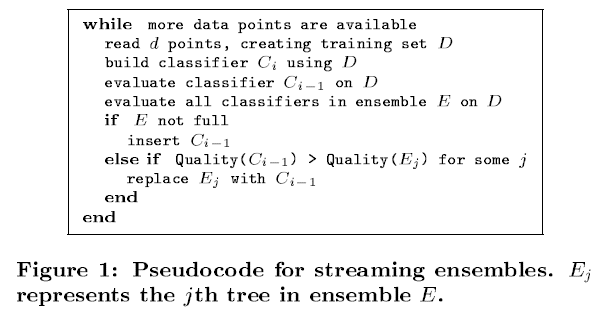

## Reacting to Different Types of Concept Drift:The Accuracy Updated Ensemble Algorithm (AUE2)

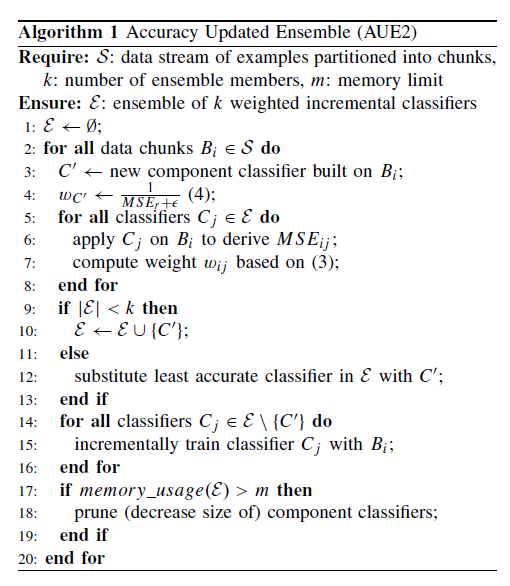

## Concept Drift Adaptation by Exploiting HistoricalKnowledge (DTEL)

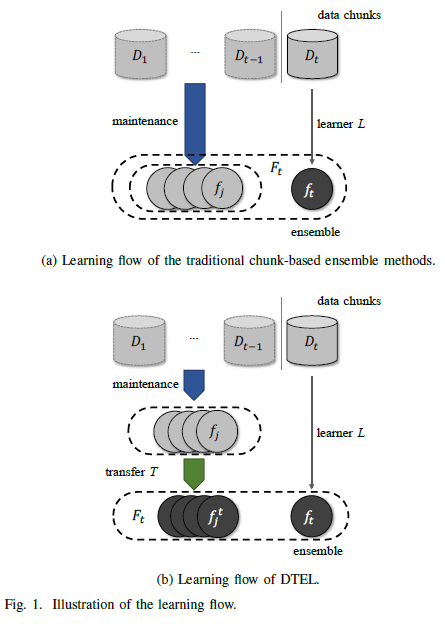

## Generative-CDTL

+ 사실 입력 $x_i$ 에서 어떤 feature가 시간에 따라 importance가 변하는지 알기 어렵다. trainset의 경우, bucket size가 크지 않을 수 있으며, 또한 I(z,b)가 분명하게 나타나지 않을 수도 있기 때문이다.
+ 따라서 아래와 같은 구조를 제안한다.
+ 실험3~4는 sensitive featrue z에 대해, G(z,b)으로 전처리 하였으나, 이번 구조는 모든 feature에 대하여 $G(x_i,b)$으로 전처리한다.
+ $I(x_i,b) > 0$ 인 feature는 G에 의해 전처리 될 것이고,$I(x_j,b) = 0$ 인 feature는 G에 의해 by-pass 되도록 학습될 것이다.

<pre>
x0 ------>|                     |- x'0 --> |                        |
x1 ------>|  Generator G(xi,b)  |- x'1 --> |                        |
x2 ------>|  (Adaptive model)   |- x'2 --> | Discriminator (D(x,g)) | -> y^
x3 ------>|                     |- x'3 --> | predictive model       |
z0 ------>|                     |- z'0 --> |                        |
                     ^
                     |
                     b
</pre>

$$
b = \{1,2,3,...N\} \in B
$$
$$
N << M
$$
$$
b_{norm} = b/M
\tag{17}
$$
$$
L_D = H(y,\hat{y}) = H(y,D(G(x_i,b_{norm})))=\mathbb{E}_{y}[-log(D(G(x_i,b_{norm})))]
\tag{21}
$$

$$
L_G = \sum_{i}MSE(G(x_i,b_{norm}),x_i)
\tag{22}
$$

$$
\min_{G(.)} L_D + L_G
\tag{23}
$$

$$
\min_{G(.)} L_D + L_G+ std(L_1,L_2)
\tag{24}
$$

# 실험
+ synthetic data를 만든다.
+ 해당 data는 data drift가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다.

## synthetic data의 생성 (Case #1 MI의 감소, Drift의 증가 )

+ $P_t(y,X) \ne P_{t+w}(y,X) $ 이고 $P_t(y|X) \ne P_{t+w}(y|X) $
+ Real concept drift
+ 즉, P(y|X)와 P(X)의 변화가 연관되어 나타남.
+ 이때 대상 feature z에 대해서 MI 감소, ks-test 통계량 증가



+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift

### Dataset 준비

In [42]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [43]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    #sns.scatterplot(x=x[:,ix],y=y)

In [44]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
#sns.scatterplot(x=x[0:200,4],y=y[0:200])
#sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

### 실험

MI Analysis MI Max 0.20278, Min 0.02707, Mean 0.09885, Std 0.06305
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:05<00:00,  5.52it/s]


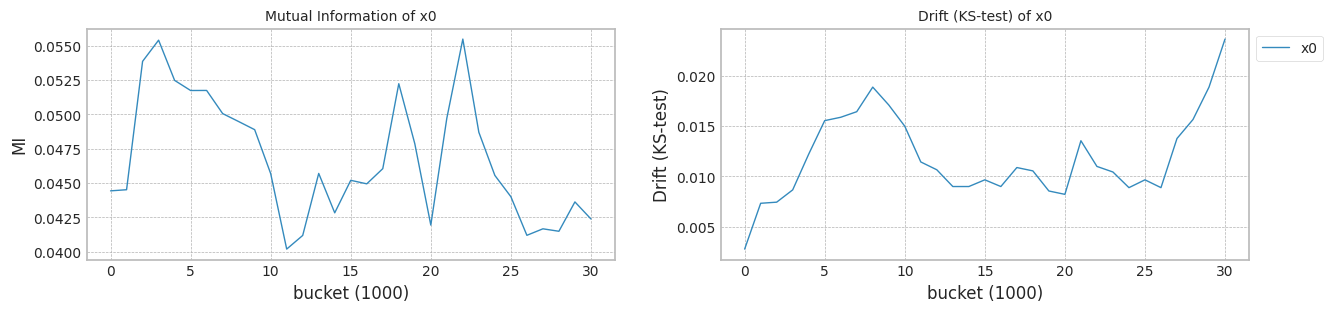

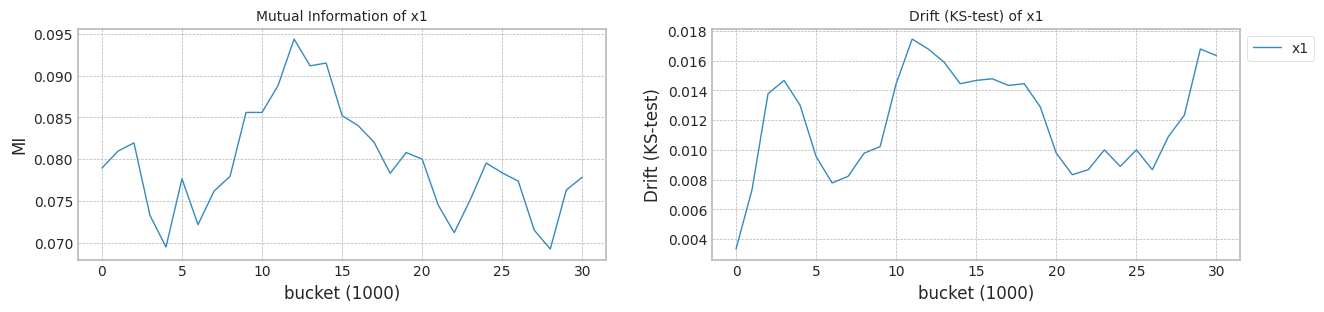

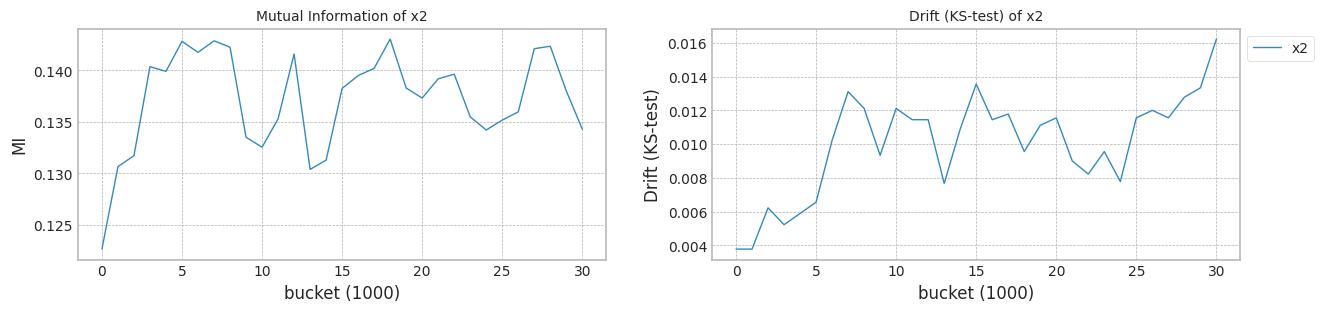

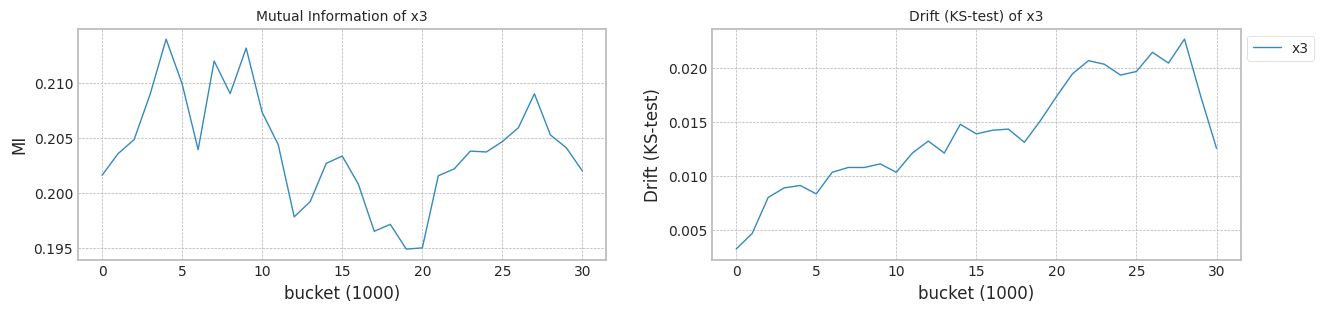

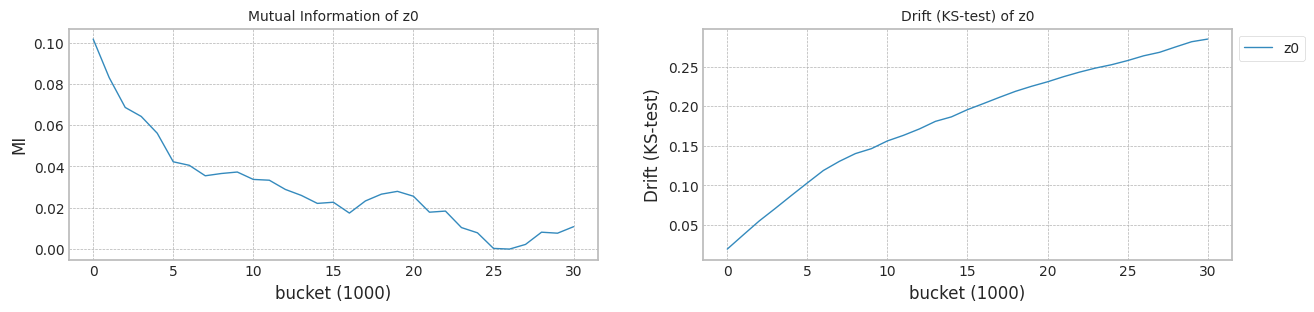

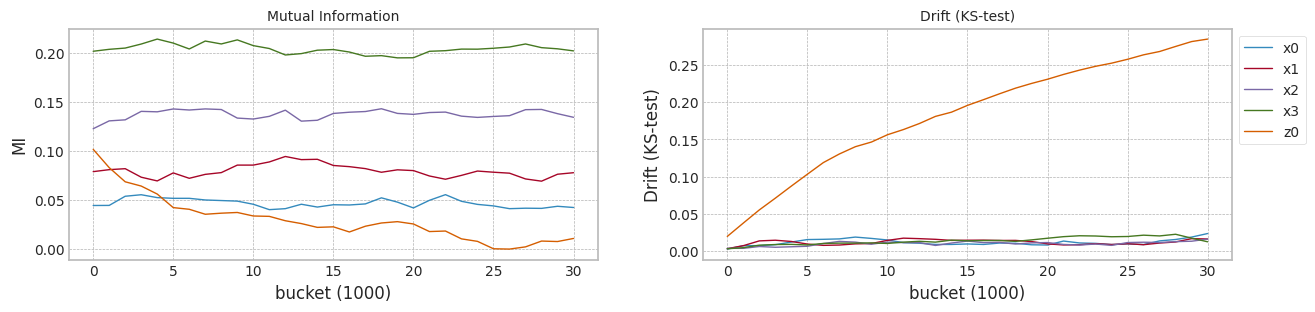

In [45]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
Y = y

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X, Y,train_size, test_size)
#model,df = train_classificaion_model(X1,Y1,train_size, test_size)

cuda:0


100%|██████████| 300/300 [00:02<00:00, 130.18it/s]


<Axes: >

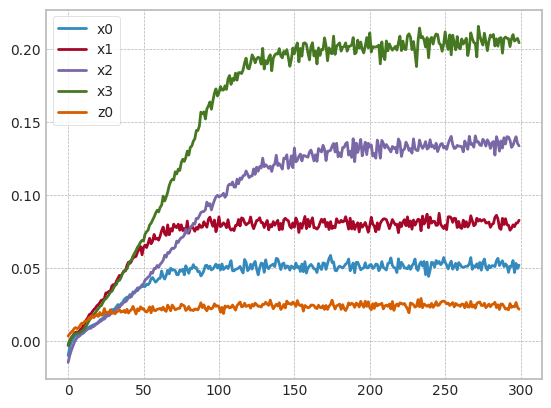

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
mine = Net(X1.shape[1]).to(device)
loss_mse = customLoss(mine).to(device)
optimizer = torch.optim.Adam(loss_mse.parameters(), lr=0.01)
plot_loss = []

x = torch.tensor(X1.values,dtype=torch.float32).to(device)
y = torch.tensor(Y1,dtype=torch.float32).to(device)

for epoch in tqdm(range(300)):
    mine.zero_grad()
    mine_loss = loss_mse(x,y)
    mine_loss.sum().backward()
    optimizer.step()
    plot_loss.append(-mine_loss.cpu().data.numpy())

plot_loss = np.asarray(plot_loss)
df_loss = pd.DataFrame(plot_loss,columns=X1.columns)

df_loss.plot()

In [47]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

,x0,x1,x2,x3,z0,b
0,0.520974,0.392205,0.600995,0.478669,0.421766,0
1,0.447230,0.556479,0.629077,0.735705,0.529014,0
2,0.489501,0.704159,0.760582,0.582973,0.570549,0
3,0.581446,0.301839,0.443337,0.515173,0.396001,0
4,0.571642,0.639275,0.524701,0.583380,0.561748,0
...,...,...,...,...,...,...
39995,0.346158,0.267147,0.513105,0.599663,0.185740,39
39996,0.426322,0.302644,0.484909,0.587518,0.721101,39
39997,0.374186,0.587769,0.624447,0.598315,0.489479,39
39998,0.470439,0.265430,0.218971,0.645349,1.258888,39


In [48]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100,trial_count=3) #np.max(X1['b']+1))

trial_count: 3
lambda_f2 1.0


NameError: ignored

In [ ]:
_,_,_,_,_,_ = drift_tolerant2(X1, Y1,train_size, test_size,avaible_range = 100,trial_count=3) #np.max(X1['b']+1))

## synthetic data의 생성 (Case #2 MI의 증감(상대적), Drift의 고정)

+ $P_t(y|X) \ne P_{t+w}(y|X)$ and $P_t(X) = P_{t+w}(X)$
+ Actual Drift
+ 즉, P(X)의 변화없이, Concept (본 Dataset에서 MI의 변화)만 변경


+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature에 대해 y의 비중이 시간에 따라 감소하도록 생성

### Dataset 준비

In [30]:
data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

In [31]:
seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

In [32]:
x1.shape

(40000, 5)

In [33]:
import matplotlib.pyplot as plt

seed_everything()

y1_array = []
cor_const = cor[4]
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)

In [34]:
m = 5 #np.mean(y1_array[0:2000])
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
print(sum(y1))

5
21325


### 실험

MI Analysis MI Max 0.22746, Min 0.00677, Mean 0.06988, Std 0.08433
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:05<00:00,  5.49it/s]


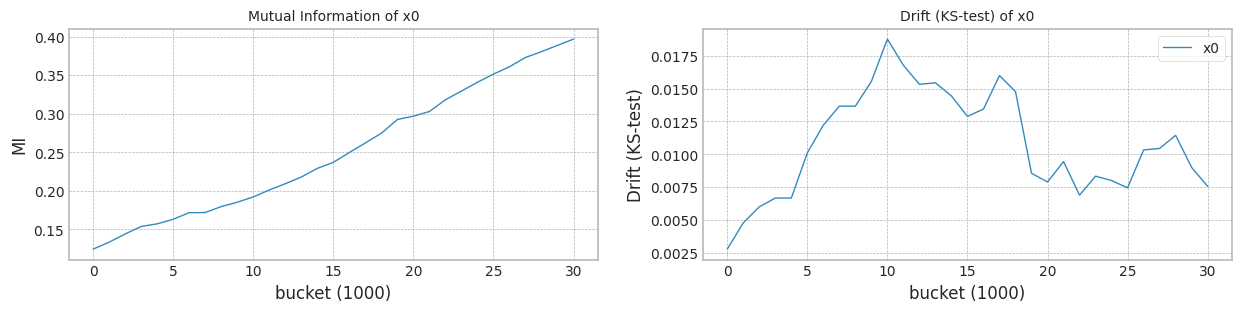

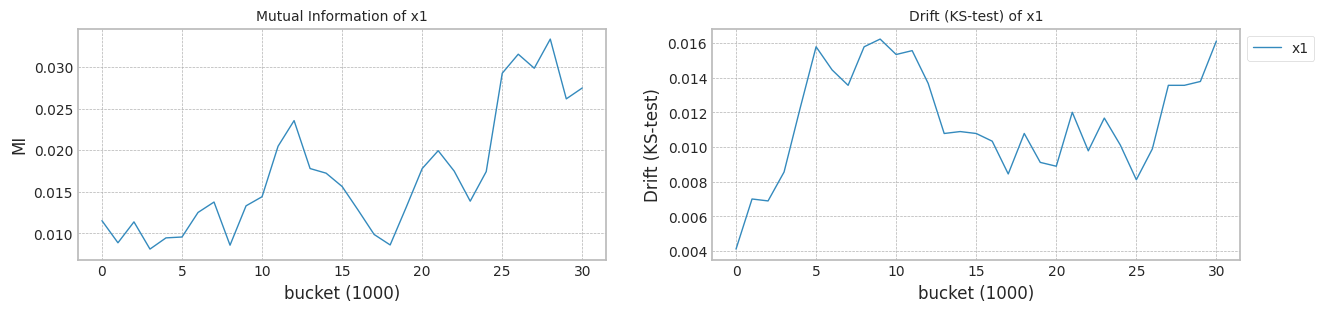

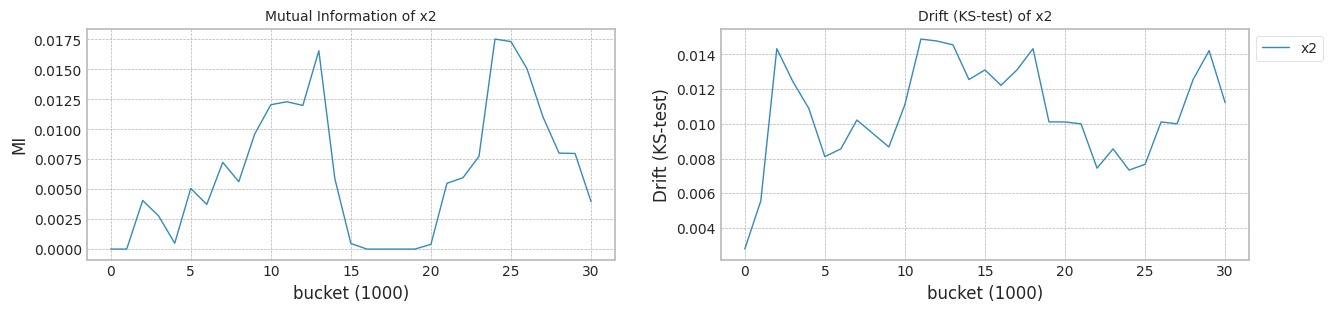

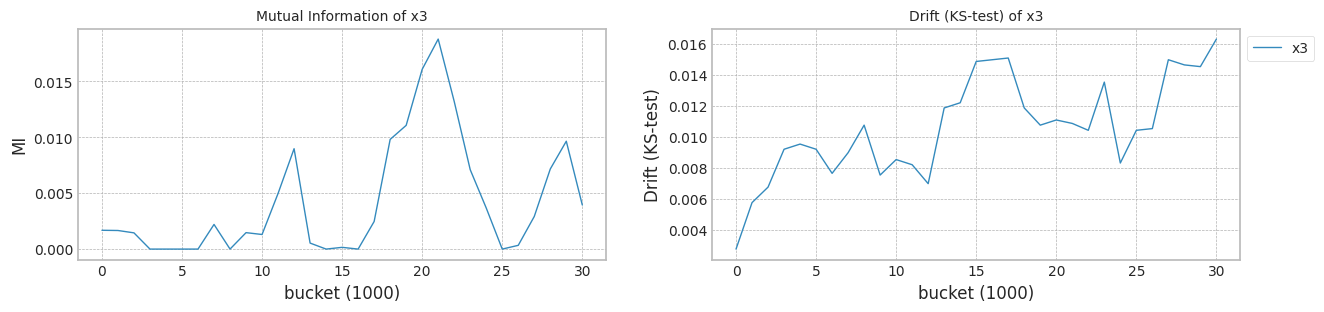

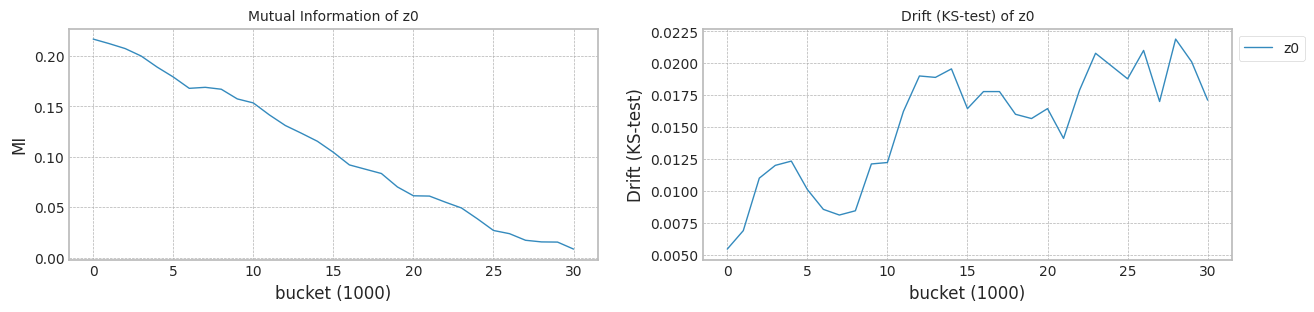

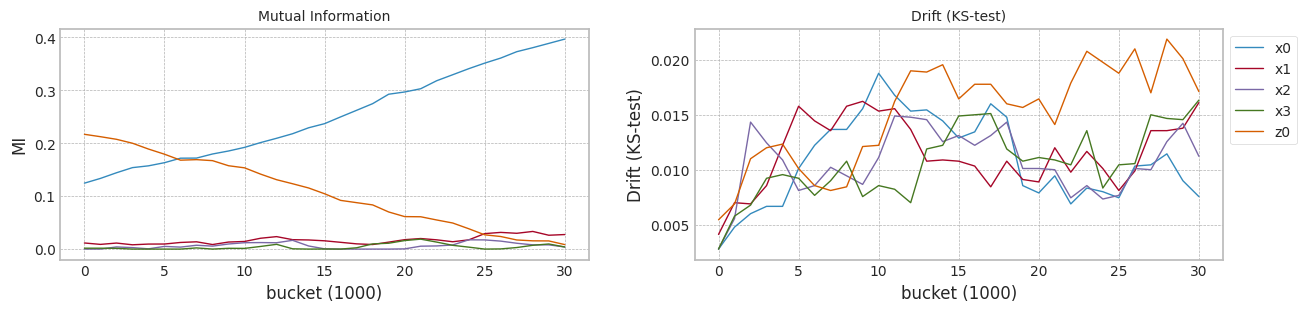

In [35]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X1, y1,train_size, test_size)
#model,df = train_classificaion_model(X1,Y1,train_size, test_size)

In [36]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

,x0,x1,x2,x3,z0,b
0,0.525799,0.497734,0.329063,0.549493,0.366139,0
1,0.610533,0.420412,0.508390,0.580336,0.662926,0
2,0.556874,0.464734,0.669603,0.724770,0.486574,0
3,0.344341,0.646524,0.340976,0.528780,0.611850,0
4,0.503142,0.550860,0.598773,0.465698,0.487044,0
...,...,...,...,...,...,...
39995,0.333622,0.399822,0.303105,0.605408,0.709407,39
39996,0.358451,0.483875,0.341855,0.574439,0.695384,39
39997,0.559469,0.343824,0.542547,0.575250,0.504288,39
39998,0.433692,0.530132,0.301231,0.282353,0.762158,39


In [37]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100,trial_count=20)

trial_count: 20
lambda_f2 1.0
######################### Trial 0 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 639.57it/s]


Test f1 score: 0.9365773646801531
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8642847292771869
######################### Trial 0 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.87it/s]


Test f1 score: 0.9518826497243764
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.33it/s]


mean of drift:
x0    0.255075
x1    0.088928
x2    0.034247
x3    0.363806
z0    0.142022
dtype: float64
Mean F1 for all data: 0.9145783443717581
Normal model mean        : 0.8642847292771869
Drift tolerant model mean: 0.9145783443717581
######################### Trial 1 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 629.28it/s]


Test f1 score: 0.9095621090259159
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.30it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.85329168099841
######################### Trial 1 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 235.30it/s]


Test f1 score: 0.9562872023809523
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.32it/s]


mean of drift:
x0    0.236735
x1    0.082477
x2    0.049910
x3    0.312204
z0    0.252222
dtype: float64
Mean F1 for all data: 0.9148450968900799
Normal model mean        : 0.8587882051377984
Drift tolerant model mean: 0.914711720630919
######################### Trial 2 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 644.89it/s]


Test f1 score: 0.9322837824200222
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.39it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8684525797318826
######################### Trial 2 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 235.78it/s]


Test f1 score: 0.930771954674221
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.16it/s]


mean of drift:
x0    0.248129
x1    0.090222
x2    0.046409
x3    0.017351
z0    0.132401
dtype: float64
Mean F1 for all data: 0.9111311012852565
Normal model mean        : 0.8620096633358264
Drift tolerant model mean: 0.9135181808490316
######################### Trial 3 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 641.09it/s]


Test f1 score: 0.9428676066654458
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.31it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8672823089981738
######################### Trial 3 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.56it/s]


Test f1 score: 0.9442556708605016
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.33it/s]


mean of drift:
x0    0.232789
x1    0.068093
x2    0.030817
x3    0.285025
z0    0.117728
dtype: float64
Mean F1 for all data: 0.8950685911120938
Normal model mean        : 0.8633278247514133
Drift tolerant model mean: 0.9089057834147971
######################### Trial 4 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 641.03it/s]


Test f1 score: 0.8506588579795021
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7940804543797344
######################### Trial 4 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.30it/s]


Test f1 score: 0.9520790602274846
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


mean of drift:
x0    0.243835
x1    0.091946
x2    0.036842
x3    0.311710
z0    0.243677
dtype: float64
Mean F1 for all data: 0.8806026664109865
Normal model mean        : 0.8494783506770777
Drift tolerant model mean: 0.903245160014035
######################### Trial 5 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 645.49it/s]


Test f1 score: 0.913331992760909
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.38it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8533114443146491
######################### Trial 5 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.59it/s]


Test f1 score: 0.9590347923681257
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.33it/s]


mean of drift:
x0    0.235989
x1    0.089319
x2    0.060889
x3    0.436756
z0    0.205978
dtype: float64
Mean F1 for all data: 0.8970693182226038
Normal model mean        : 0.8501171996166729
Drift tolerant model mean: 0.9022158530487965
######################### Trial 6 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 638.38it/s]


Test f1 score: 0.9217391304347826
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8645762925076509
######################### Trial 6 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 235.03it/s]


Test f1 score: 0.968361581920904
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.254713
x1    0.067674
x2    0.042527
x3    0.550939
z0    0.132441
dtype: float64
Mean F1 for all data: 0.9247165604403103
Normal model mean        : 0.852182784315384
Drift tolerant model mean: 0.9054302398190127
######################### Trial 7 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 647.45it/s]


Test f1 score: 0.9312034852060266
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.39it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8725484348557931
######################### Trial 7 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 237.92it/s]


Test f1 score: 0.9405604042259991
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.39it/s]


mean of drift:
x0    0.180964
x1    0.077029
x2    0.068968
x3    0.170226
z0    0.242853
dtype: float64
Mean F1 for all data: 0.8972986252940278
Normal model mean        : 0.8547284906329351
Drift tolerant model mean: 0.9044137880033896
######################### Trial 8 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 623.34it/s]


Test f1 score: 0.9285453882610282
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.45it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8574496308114765
######################### Trial 8 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 236.55it/s]


Test f1 score: 0.962087087087087
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.254599
x1    0.101900
x2    0.065993
x3    0.327939
z0    0.135599
dtype: float64
Mean F1 for all data: 0.9070095066184277
Normal model mean        : 0.8550308395416619
Drift tolerant model mean: 0.9047022011828383
######################### Trial 9 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 636.35it/s]


Test f1 score: 0.9091879391621452
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.44it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8498517790280777
######################### Trial 9 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 235.71it/s]


Test f1 score: 0.9306613226452906
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.33it/s]


mean of drift:
x0    0.189642
x1    0.072158
x2    0.026631
x3    0.170677
z0    0.231842
dtype: float64
Mean F1 for all data: 0.8324849474923853
Normal model mean        : 0.8545129334903034
Drift tolerant model mean: 0.897480475813793
######################### Trial 10 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 643.94it/s]


Test f1 score: 0.8818354321200622
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8233670716383916
######################### Trial 10 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 235.62it/s]


Test f1 score: 0.9601571268237935
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.245151
x1    0.090799
x2    0.041437
x3    0.323358
z0    0.287168
dtype: float64
Mean F1 for all data: 0.8719856310532021
Normal model mean        : 0.851681491503766
Drift tolerant model mean: 0.8951627626537392
######################### Trial 11 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 648.91it/s]


Test f1 score: 0.8563283922462942
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.41it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8073247648474384
######################### Trial 11 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 237.57it/s]


Test f1 score: 0.9571708500513203
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.261154
x1    0.108301
x2    0.043821
x3    0.370513
z0    0.204000
dtype: float64
Mean F1 for all data: 0.8906323125022076
Normal model mean        : 0.8479850976157387
Drift tolerant model mean: 0.8947852251411116
######################### Trial 12 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 638.88it/s]


Test f1 score: 0.9238424045491471
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.38it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8742951737528983
######################### Trial 12 for Drift tolerant model ###########################
cuda:0


  9%|▉         | 358/4000 [00:01<00:15, 233.35it/s]


KeyboardInterrupt: ignored

In [ ]:
_,_,_,_,_,_ = drift_tolerant2(X1, Y1,train_size, test_size,avaible_range = 100,trial_count=20) #np.max(X1['b']+1))


## synthetic data의 생성 (Case #3 MI의 증감(상대적), Drift의 증가)

+ $P_t(y,X) \ne P_{t+w}(y,X) $ 이고 $P_t(y|X) \ne P_{t+w}(y|X) $
+ Real concept drift
+ 즉, P(y|X)와 P(X)의 변화가 연관되어 나타남.
+ 이때 대상 feature $z_0$에 대해서 MI 증가, ks-test 통계량 증가
+ 이에따라 $X_0$의 MI 감소

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift, MI는 고정

### Dataset 준비

In [ ]:
import matplotlib.pyplot as plt

cor = np.asarray([2.5, 1.2, 0.9 , 0.7, 1.5])

seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

seed_everything()

y1_array = []
cor_const = cor[0]
for ii in range(x1.shape[0]):
    cor[0] = cor[0] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    e1 = np.random.normal(0.0,  4*ii/40000)
    x1[ii,4] = x1[ii,4] + e1
    y1_array.append(np.sum(cor * x1[ii])+e)

In [ ]:
m = np.mean(y1_array)
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
sum(y1)

### 실험

In [ ]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X1, y1,train_size, test_size)

In [ ]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

In [ ]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100,trial_count=20)

In [ ]:
_,_,_,_,_,_ = drift_tolerant2(X1, Y1,train_size, test_size,avaible_range = 100,trial_count=20) #np.max(X1['b']+1))


## synthetic data의 생성 (Case #4 MI의 고정, Drift의 증가)

+ $P_t(y|X) = P_{t+w}(y|X)$ and $P_t(X) \ne P_{t+w}(X)$
+ Virtual Drift
+ 즉, Concept (본 Dataset에서 MI의 변화)의 변화는 없고, P(X)만 변함.

### Dataset 준비

In [ ]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

y3= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x3 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    '''
    x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)
    '''
    # z0
    if ix == 4:
        for ii in range(len(y3)):
            x3[ii,ix] = y3[ii] + np.random.normal(0.0 + 4*ii/data_size,cor_)
    else:
        x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)


### 실험

In [ ]:
columns=['x0','x1','x2','x3','z0']
X3 = pd.DataFrame(x3,columns=columns)

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X3, y3,train_size, test_size)

In [ ]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

In [ ]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100,trial_count=20)

In [ ]:
_,_,_,_,_,_ = drift_tolerant2(X1, Y1,train_size, test_size,avaible_range = 100,trial_count=20) #np.max(X1['b']+1))


## synthetic data의 생성 (Case #5 - Case #1,2,3,4의 상황이 각 feature에 혼재되어 있는 경우)

+ $P_t(y,X) \ne P_{t+w}(y,X) $ 이고 $P_t(y|X) \ne P_{t+w}(y|X) $
+ 전체적으로는 Real concept drift
+ 즉, P(y|X)와 P(X)의 변화가 연관되어 나타남.
+ $x_0$ : No drift
+ $x_1$ : $P_t(y|X) = P_{t+w}(y|X)$ 이면서 $P_t(X) \ne P_{t+w}(X)$ 인 Virtual Drift
+ $x_2$ : $P_t(y|X) \ne P_{t+w}(y|X)$ 이면서 $P_t(X) \ne P_{t+w}(X)$ 인 Real Concept Drift, MI 감소, Drift 증가
+ $x_3$ : $P_t(y|X) \ne P_{t+w}(y|X)$ 이면서 $P_t(X) \ne P_{t+w}(X)$ 인 Real Concept Drift, MI 증가, Drift 증가
+ $z_0$ : $P_t(y|X) \ne P_{t+w}(y|X)$ 이면서 $P_t(X) = P_{t+w}(X)$ 인 Actual Drift, MI 감소, Drift 고정


### Dataset 준비

In [ ]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x4 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x4[:,ix] = np.random.normal(1,cor_,data_size)

y4_array = []
cor_const = cor[4]
cor_const2 = 3/x4.shape[0]
for ii in range(x4.shape[0]):
    # Case #2, MI의 증감(상대적), Drift의 고정 - z0
    cor[4] = cor[4] - cor_const / x4.shape[0]
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 증감(상대적), Drift의 증가 - x3
    e1 = np.random.normal(0.0, 3*cor_const2 * ii)
    x4[ii,3] = x4[ii,3] + e1
    y4_array.append(np.sum(cor * x4[ii])+e)

y4 = [1 if y_ > 5 else 0 for y_ in y4_array]

for i in range(len(y4)):
    #Case #1 MI의 감소, Drift의 증가 - x2
    x4[i,2] = y4[i] + np.random.normal(1,0.5+(i/data_size))
    #Case #4 MI의 고정, Drift의 증가 - x1
    x4[i,1] = y4[i] + np.random.normal(0.0 + 4*(i/data_size),cor[1])


### 실험

In [ ]:
columns=['x0','x1','x2','x3','z0']
X4 = pd.DataFrame(x4,columns=columns)

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X4, y4,train_size, test_size)

In [ ]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]


In [ ]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100,trial_count=20)

In [ ]:
_,_,_,_,_,_ = drift_tolerant2(X1, Y1,train_size, test_size,avaible_range = 100,trial_count=20) #np.max(X1['b'])+1)

## real-world data 의 실험

### Loan data 실험

#### Dataset 준비

##### Data load

In [ ]:

if True:
    from google.colab import drive
    drive.mount('/content/drive')

In [ ]:

df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

##### Data 정제

In [ ]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# maybe we can go further, and eliminate columns up to title:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():
df_accepted = df_accepted.dropna()
print(df_accepted.shape)

# These are constant columns. We can drop it either.
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

df_accepted

In [ ]:
# droping constant columns
print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)
print(df_accepted.shape)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
print(df_accepted.shape)


df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

df_accepted.info()

##### Dataset 만들기

In [ ]:
X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

In [ ]:

X[2010].shape

In [ ]:
COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

In [ ]:
seed_everything(12)

X_df = pd.DataFrame(X[2010],columns=COLUMNS)
mi_scores = make_mi_scores(X_df, Y[2010], discrete_features="auto")
print(mi_scores)

In [ ]:
# MI Top 5, columns
top_columns = list(mi_scores[0:5].index)
top_columns

#### 실험

In [ ]:
# 1/10 로 사이즈 줄이기...
seed_everything()

X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
s = np.sort(np.random.choice(X2.shape[0],int(X2.shape[0]/10),replace= False))
#print(s.shape)
X3 = pd.DataFrame(X2[s],columns=COLUMNS)
Y3 = Y2[s]



##### weight 초기화

In [ ]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, avaible_range, alpha, columns,ShowChart = False, do_mine=True):
    #seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    lambda_f = torch.tensor([lambda_f],dtype=torch.float32).to(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    #s1_test = test_tensors.s1_test.to(device)

    # Saves return values here
    #test_result = []

    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch

    b_dim = XS_train.shape[1]-1

    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    a_losses = []
    m_losses =[]
    f_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss(reduce=False)  # mean square error

    # Initializes generator and discriminator
    discriminator = Discriminator(b_dim).to(device)
    discriminator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(discriminator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]


    adapter = Generator(b_dim).to(device)
    adapter.apply(weights_init_normal)

    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net(b_dim).to(device)

    mine_loss = customLoss(mine).to(device)
    optimizer_M = torch.optim.Adam(mine_loss.parameters(), lr=0.001)
    #kld_loss = nn.KLDivLoss(reduction='batchmean')
    default_value = torch.tensor([0.5],dtype=torch.float32).to(device)
    for epoch in tqdm(range(n_epochs)):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------

        if lambda_f >= 0.0:
            xs = adapter(XS_train[:,0:b_dim],XS_train[:,b_dim].reshape(-1,1)/avaible_range) # z0, b

            #org = torch.histc(XS_train[:,0:b_dim], bins=100, min=0, max=1)
            #trg = torch.histc(xs, bins=100, min=0, max=1)

            ml = torch.mean(mse_loss(xs, XS_train[:,0:b_dim]),dim=0)

            ## distribution의 변차를 최소화 한다. kld_loss ??
            #kl = torch.mean(kld_loss(trg.log(), org),dim=0)
            #
            a_loss =  torch.sum(ml) + torch.std(ml)
        else:
            xs = XS_train[:,0:b_dim]
            a_loss = torch.tensor(0.0)

        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = discriminator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) #+ torch.log(mine_loss.mean()+1)*0.001

        optimizer_A.zero_grad()
        #optimizer_M.zero_grad()
        optimizer_G.zero_grad()
        '''
        if lambda_f >= 0.0:
            # -------------------
            #  Forwards MINE
            # -------------------

            xs_test = adapter(XS_test[:,0:b_dim],XS_test[:,b_dim].reshape(-1,1)/avaible_range)
            #x_sample = Variable(torch.clone(xs_test), requires_grad = True)

            m_loss, lmd = mine_loss(xs_test,
                                    y_test, #generator(xs_test).reshape(-1,1),
                                    default_value)

            m_losses.append(-m_loss.cpu().data.numpy())
            f_losses.append(lmd.cpu().data.numpy())

            m_loss = m_loss.sum() * 0.01
            #m_loss.mean().backward()

            #lambda_f = lmd #.detach()
        else:
            m_loss = torch.tensor(0.0)
        '''

        lambda1 = 0.7

        if lambda_f >= 0.0:
            #loss =  lambda1*g_loss + (1-lambda1)*a_loss + torch.std(torch.tensor((g_loss,a_loss)))   #(1.0-lambda_f) * g_loss + lambda_f * a_loss + m_loss.mean()*0.01
            loss =  g_loss + a_loss + torch.std(torch.tensor((g_loss,a_loss)))
        else:
            loss = g_loss

        loss.backward()

        optimizer_G.step()
        #optimizer_M.step()
        optimizer_A.step()

        a_losses.append(a_loss.cpu().data.numpy())
        g_losses.append(g_loss.cpu().data.numpy())

        '''
        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [a loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, a_losses[-1], g_losses[-1])
                )
        '''
        if lambda_f < 0.0:
            adapter = None

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1 = test_model(discriminator,adapter, train_tensors, test_tensors, avaible_range,columns)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    df_loss = pd.DataFrame({'Generator loss':a_losses,'Predictor loss':g_losses})
    if ShowChart:
        df_loss.plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel=f'bucket ({XS_train.shape[0]})',fontsize=15)
        plt.legend(loc=1)
        plt.show()
    '''
    if lambda_f >= 0.0:
        plt.figure(figsize=main_figsize)
        mi_df = pd.DataFrame(m_losses,columns=columns)
        mi_df.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='epoch',fontsize=10)
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

        plt.figure(figsize=main_figsize)
        #plt.plot(a_losses,linewidth=1,label='Adapter loss')
        #plt.plot(g_losses,linewidth=1,label='classifier loss')
        plt.plot(f_losses,linewidth=1,label='lambda')
        plt.ylabel('lambda')
        plt.xlabel('epoch')
        plt.legend(loc=1,ncol=1)
        plt.show()
    '''
    return f1,discriminator,adapter,df_loss

#### do

In [ ]:
seed_everything()

#s = np.sort(np.random.choice(len(COLUMNS),2,replace= False))
top_columns = list(mi_scores[0:5].index)
top_columns
print('columns:',top_columns)
#print(s.shape)
X4 = X3[top_columns]

train_size = 10000*2
test_size = 2000*2

X1,Y1 = check_mi_drift(X4, Y3, train_size, test_size)

bucket_size = 500*2
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 600,trial_count=20)

In [ ]:
seed_everything()

#s = np.sort(np.random.choice(len(COLUMNS),2,replace= False))
top_columns = list(mi_scores[0:5].index)
top_columns
print('columns:',top_columns)
#print(s.shape)
X4 = X3[top_columns]

train_size = 10000*2
test_size = 2000*2

X1,Y1 = check_mi_drift(X4, Y3, train_size, test_size)

bucket_size = 500*2
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
_,_,_,_,_,_ = drift_tolerant2(X1, Y1,train_size, test_size,avaible_range = 600,trial_count=20)

### #2 날짜 단위로 bucket 만들기

#### data 정제

In [ ]:
X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
#df = df.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    #df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values


In [ ]:
COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

In [ ]:
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = list(COLUMNS))#[top_columns+['issue_d']]

In [ ]:
X2

In [ ]:
from datetime import date
from datetime import datetime

def date_bucket_num(d,start_day='20100101'):
    date1 = datetime.strptime(start_day, '%Y%m%d')
    date2 = datetime.strptime(str(d)+'01', '%Y%m%d')
    delta = date2 - date1
    return int(delta.days/30)

In [ ]:
X2['b'] = [date_bucket_num(d) for d in X2['issue_d']]

In [ ]:
b_cnt = X2.groupby(['b'])['b'].count()

In [ ]:
# 1/10 로 사이즈 줄이기...
seed_everything()
s = np.sort(np.random.choice(X2.shape[0],int(X2.shape[0]/10),replace= False))
#print(s.shape)
X3 = X2.iloc[s,:]
Y3 = Y2[s]

In [ ]:
b_cnt2 = X3.groupby(['b'])['b'].count()

In [ ]:
fig, ax = plt.subplots(figsize=main_figsize, nrows=1, ncols=2)
ax[0].bar(b_cnt.index,b_cnt.values)
ax[0].set_ylabel('count')
ax[0].set_xlabel('month (from 201001)')
ax[0].set_title(f'Histogram per month for full dataset',fontdict={'fontsize':10})

ax[1].bar(b_cnt2.index,b_cnt2.values)
ax[1].set_ylabel('count')
ax[1].set_xlabel('month (from 201001)')
ax[1].set_title(f'Histogram per month for reduced(1/10) dataset',fontdict={'fontsize':10})

plt.show()

In [ ]:
X3.drop(columns=['issue_d'],inplace=True)

In [ ]:
X3

#### Drift tolerant 학습

In [ ]:
from more_itertools import locate
def find_indices(list_to_check, item_to_find):
    indices = locate(list_to_check, lambda x: x == item_to_find)
    return list(indices)

In [ ]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

def check_mi_drift(X:pd.DataFrame,Y:np.array,train_size:int,test_size:int):

    columns = X.columns
    is_Has_bucket = False
    # 'b' 즉, bucket count 가 있으며, 'b'를 제외 시킨다.
    if 'b' in columns:
        print('Dataset has buckets!')
        columns = columns[0:-1]
        buckets = list(X['b'])
        X = X[columns]
        is_Has_bucket = True

    mi_scores = make_mi_scores(X, Y, discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    scaler_c1 = MinMaxScaler()
    # trainset을 가지고 Scaler를 fit하고, testset을 포함한 그 이후의 Data를 모두 transform 한다.
    X = pd.DataFrame(np.concatenate((scaler_c1.fit_transform(X[0:train_size]), scaler_c1.transform(X[train_size:])),axis=0), columns=columns)

    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    if is_Has_bucket:
        b_min = min(buckets[-X_live.shape[0]:])
        b_max = max(buckets[-X_live.shape[0]:])
        print(f'bucket range in live set {b_min}~{b_max}')
        for i in range(b_min,b_max+1):
            s = find_indices(buckets,i)
            if len(s) > 0:
                xl = X.iloc[s]
                yl = Y[s]
                X_live_set.append(xl)
                Y_live_set.append(yl)
    else:
        for i in range(int(X_live.shape[0]/test_size)):
            xl = X_live[i*test_size:i*test_size+train_size]
            yl = Y_live[i*test_size:i*test_size+train_size]

            if len(xl) ==  train_size:
                X_live_set.append(xl)
                Y_live_set.append(yl)
            else:
                #print(xl.shape)
                truncate_count = xl.shape[0] #truncate_count + len(xl)
                break

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = np.asarray(X_live_set)
    Y_live_set = np.asarray(Y_live_set)

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        X_live_unit = pd.DataFrame(X_live_unit,columns = columns)
        mi_scores = make_mi_scores(X_live_unit, Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,X_live_unit.values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    for c_name in df_mis.columns:
        fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
        df_mis[c_name].plot(ax=ax[0],linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',legend=None)
        ax[0].set_title(f'Mutual Information of {c_name}',fontdict={'fontsize':10})

        df_drf[c_name].plot(ax=ax[1],linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})')
        ax[1].set_title(f'Drift (KS-test) of {c_name}',fontdict={'fontsize':10})
        ax[1].legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

    fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
    df_mis.plot(ax=ax[0],linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',legend=None)
    ax[0].set_title(f'Mutual Information',fontdict={'fontsize':10})

    df_drf.plot(ax=ax[1],linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})')
    ax[1].set_title(f'Drift (KS-test)',fontdict={'fontsize':10})
    ax[1].legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    if is_Has_bucket:
        X['b'] = buckets
    return X,Y

In [ ]:
top_columns = list(mi_scores[0:5].index)
top_columns

train_size = X3[X3['b'] < 46].shape[0] # 2010년 1월에서 39개월 (약 3년6개월간의 data)
print('train_size',train_size)
test_size = 4000

X1,Y1 = check_mi_drift(X3[top_columns+['b']], Y3, train_size, test_size)

In [ ]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 600,trial_count=20)

In [ ]:
_,_,_,_,_,_ = drift_tolerant2(X1, Y1,train_size, test_size,avaible_range = 600,trial_count=20)

In [ ]:
top_columns = list(mi_scores[0:10].index)
top_columns

train_size = X3[X3['b'] < 46].shape[0] # 2010년 1월에서 39개월 (약 3년6개월간의 data)
print('train_size',train_size)
test_size = 4000

X1,Y1 = check_mi_drift(X3[top_columns+['b']], Y3, train_size, test_size)

In [ ]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 400,trial_count=20)

In [ ]:
_,_,_,_,_,_ = drift_tolerant2(X1, Y1,train_size, test_size,avaible_range = 400,trial_count=20)